# 4. Classification – Applied

Excercises from **Chapter 4** of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

I've elected to use Python instead of R.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import datasets
from IPython.display import display, HTML

### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [122]:
# Clarifying orientation of confusion matrix
# Here we see that 
# - rows i represent true values
# - columns j represent predictions


y_true = [1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]

confusion_matrix(y_true, y_pred)

array([[2, 0],
       [1, 3]], dtype=int64)

In [124]:
from sklearn.metrics import confusion_matrix

def confusion_table(confusion_mtx):
    """Renders a nice confusion table with labels"""
    confusion_df = pd.DataFrame({'y_pred=0': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=1': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=0', 'y=1', 'Total']}).set_index('')
    return confusion_df


def positive_observations(y):
    # What percentage of observations are positive?
    proportion_1 = ((y == 1).sum() / len(y))
    pct_1        = np.around(proportion_1*100, decimals=3)
    display(HTML('<p><h4>{}%</h4>of observations are positive</p>'.format(pct_1)))


# Classifier stats
# -------------------------------------------------

def prior_error_rate(confusion_matrix):
    """The prior probability that a result is positive"""
    return 1 - (np.sum(confusion_mtx[1, :]) / np.sum(confusion_mtx))

def total_error_rate(confusion_matrix):
    """Derive total error rate from confusion matrix"""
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx)

def true_positive_rate(confusion_mtx):
    """or sensitivity: the proportion of actual POSITIVES that are correctly identified as such"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[1, :])

def false_negative_rate(confusion_mtx):
    """the proportion of actual POSITIVES that are incorrectly identified as negative"""
    return confusion_mtx[1, 0] / np.sum(confusion_mtx[1, :])

def false_positive_rate(confusion_mtx):
    """the proportion of actual NEGATIVES that are incorrectly identified as positives"""
    return confusion_mtx[0, 1] / np.sum(confusion_mtx[0, :])

def true_negative_rate(confusion_mtx):
    """or specificity: the proportion of actual NEGATIVES that are correctly identified as such"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[0, :])

def positive_predictive_value(confusion_mtx):
    """or precision: the proportion of predicted positives that are correctly predicted"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[:, 1])

def negative_predictive_value(confusion_mtx):
    """the proportion of predicted negatives that are correctly predicted"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])

def classifier_stats(confusion_mtx):
    return pd.Series({'prior_error_rate': prior_error_rate(confusion_mtx),
                      'total_error_rate': total_error_rate(confusion_mtx),
                      'true_positive_rate (sensitivity)': true_positive_rate(confusion_mtx),
                      'false_negative_rate': false_negative_rate(confusion_mtx),
                      'false_positive_rate': false_positive_rate(confusion_mtx),
                      'true_negative_rate (specificity)': true_negative_rate(confusion_mtx),
                      'positive_predictive_value (precision)': positive_predictive_value(confusion_mtx),
                      'negative_predictive_value': negative_predictive_value(confusion_mtx)})


## 11. In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

### (a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() function. Note you may find it helpful to use the data.frame() function to create a single data set containing both mpg01 and the other Auto variables.

In [125]:
auto_df = pd.read_csv('./data/auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()
print(auto_df)
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin'],
             'qual': ['name']}

quants = auto_df[datatypes['quant']].astype(np.float_)
auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

# Add mpg01 feature
mpg01   = (auto_df['mpg'] > auto_df['mpg'].median()).astype(np.float64)
auto_df = pd.concat([auto_df, mpg01.rename('mpg01')], axis=1).drop('mpg', axis=1)
auto_df.head()

display(auto_df.head())

     index   mpg  cylinders  displacement  horsepower  weight  acceleration  \
0        0  18.0          8         307.0         130    3504          12.0   
1        1  15.0          8         350.0         165    3693          11.5   
2        2  18.0          8         318.0         150    3436          11.0   
3        3  16.0          8         304.0         150    3433          12.0   
4        4  17.0          8         302.0         140    3449          10.5   
..     ...   ...        ...           ...         ...     ...           ...   
387    387  27.0          4         140.0          86    2790          15.6   
388    388  44.0          4          97.0          52    2130          24.6   
389    389  32.0          4         135.0          84    2295          11.6   
390    390  28.0          4         120.0          79    2625          18.6   
391    391  31.0          4         119.0          82    2720          19.4   

     year  origin                       name  
0   

,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0


### (b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.


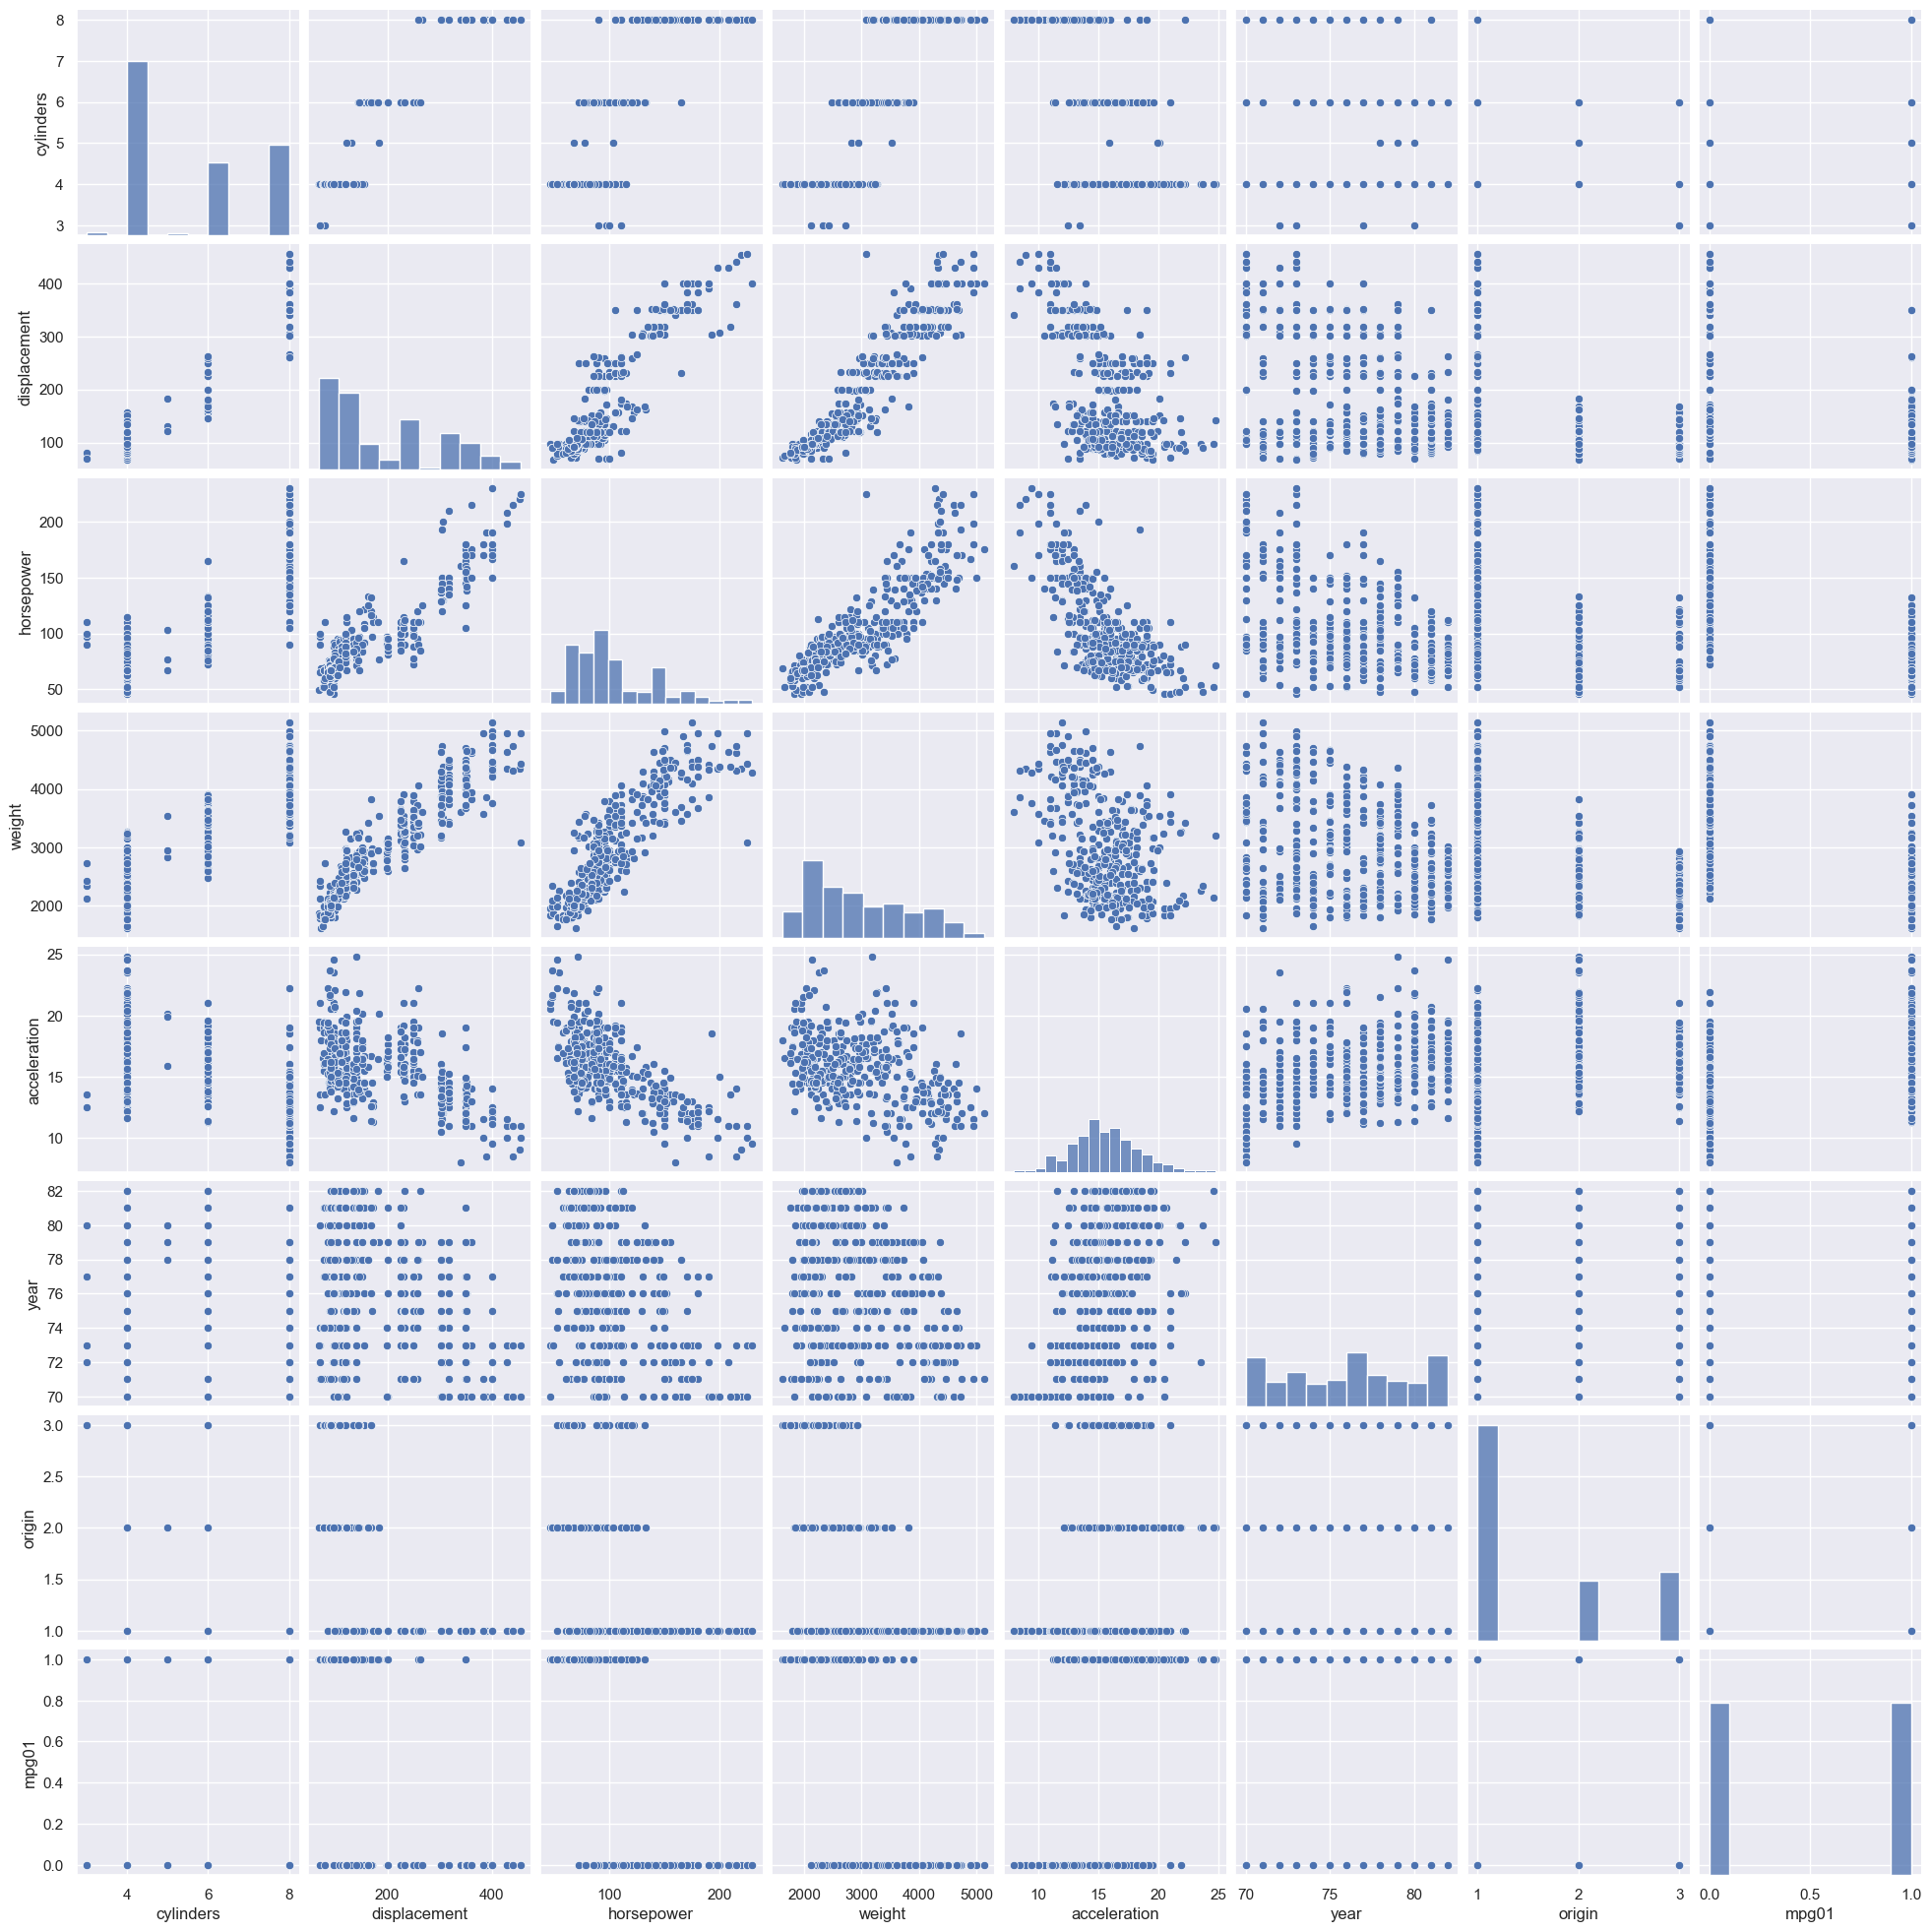

In [126]:
sns.pairplot(auto_df);

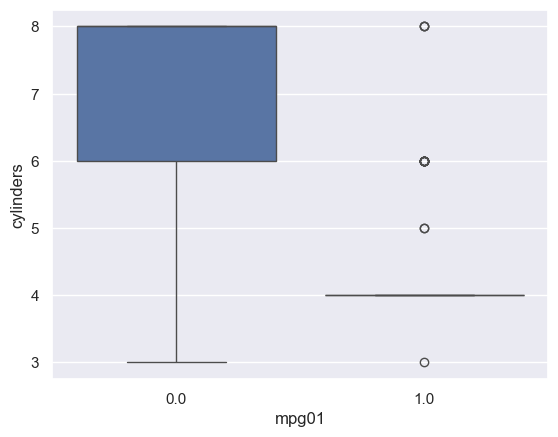

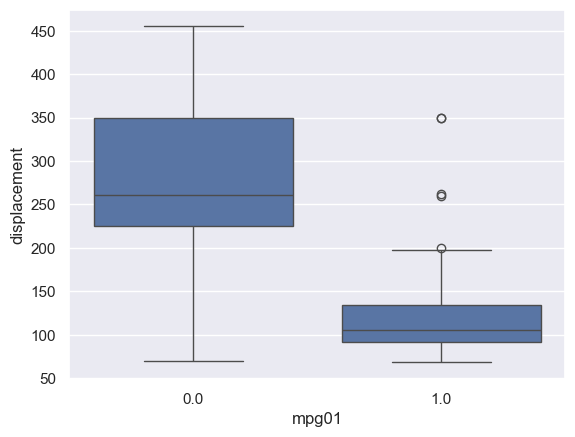

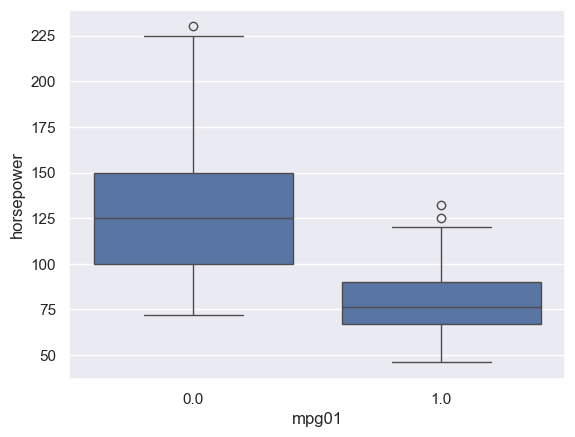

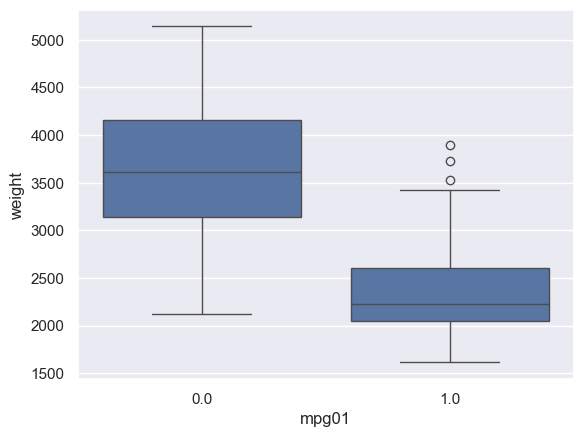

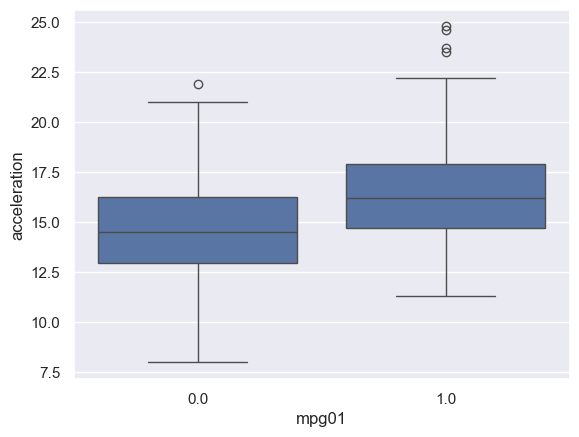

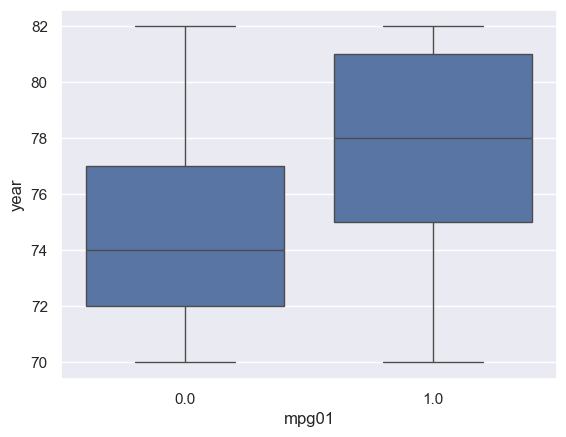

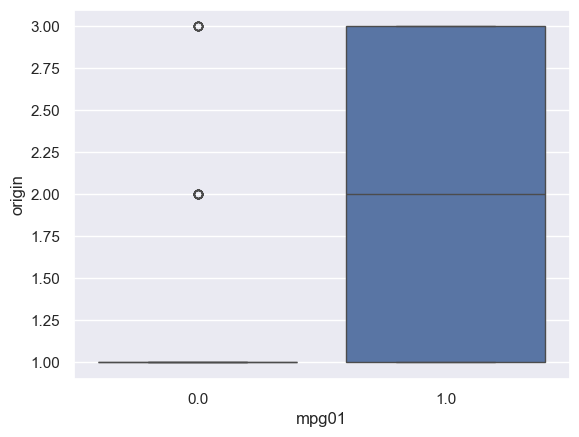

In [127]:
for c in auto_df.columns.drop(['mpg01', 'name']):
    sns.boxplot(x=auto_df['mpg01'], y=auto_df[c])
    plt.show();

Weight, displacement and cyclinders look like the most predictive features.

### (c) Split the data into a training set and a test set.

In [128]:
# Create index for training set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

# Training set (70%)
display(HTML('<h3>Training set</h3>'))
display(auto_df[train].head())

# Test set (30%)
display(HTML('<h3>Test set</h3>'))
display(auto_df[~train].head())


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0
5,8.0,429.0,198.0,4341.0,10.0,70.0,1.0,ford galaxie 500,0.0


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
13,8.0,455.0,225.0,3086.0,10.0,70.0,1.0,buick estate wagon (sw),0.0
20,4.0,110.0,87.0,2672.0,17.5,70.0,2.0,peugeot 504,1.0
21,4.0,107.0,90.0,2430.0,14.5,70.0,2.0,audi 100 ls,1.0
24,6.0,199.0,90.0,2648.0,15.0,70.0,1.0,amc gremlin,0.0


In [129]:


# Create index for training set
np.random.seed(1)
train_idx = np.random.rand(len(auto_df)) < 0.7
auto_df_train = auto_df[train_idx]
auto_df_test  = auto_df[~train_idx]

### (d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

### (e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

### (f) Perform logistic regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [130]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)


models = {'logit': model_logit, 
          'lda': model_lda, 
          'qda': model_qda}
scaled = []


# PREDICT
for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(classifier_stats(confusion_mtx))



,y_pred=0,y_pred=1,Total
,,,
y=0,56,10,66
y=1,4,50,54
Total,60,60,


prior_error_rate                         0.550000
total_error_rate                         0.116667
true_positive_rate (sensitivity)         0.925926
false_negative_rate                      0.074074
false_positive_rate                      0.151515
true_negative_rate (specificity)         0.848485
positive_predictive_value (precision)    0.833333
negative_predictive_value                0.933333
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,56,10,66
y=1,2,52,54
Total,58,62,


prior_error_rate                         0.550000
total_error_rate                         0.100000
true_positive_rate (sensitivity)         0.962963
false_negative_rate                      0.037037
false_positive_rate                      0.151515
true_negative_rate (specificity)         0.848485
positive_predictive_value (precision)    0.838710
negative_predictive_value                0.965517
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


prior_error_rate                         0.550000
total_error_rate                         0.091667
true_positive_rate (sensitivity)         0.962963
false_negative_rate                      0.037037
false_positive_rate                      0.136364
true_negative_rate (specificity)         0.863636
positive_predictive_value (precision)    0.852459
negative_predictive_value                0.966102
dtype: float64

**Comment**

After some experimentation with features, I achieved the lowest total error rates with with 'weight', 'cylinders', 'year', 'acceleration'.

Without acceleration linear models were superior. Adding acceleration had no effect on linear models but improved qda suggesting that the addition of acceleration adds a non-linear relationship which linear models are unable to represent.

The QDA result can be achieved with LDA by taking log of predictors.

### (g) Perform KNN on the training data, with several values of K, in order to predict mpg01. Use only the variables that seemed most associated with mpg01 in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?



In [131]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])



# PREDICT
for K in range(1, 21):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
    # Predict
    y_pred = model.predict(preprocessing.scale(X_test))
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    
    # Classifier stats
    print('total_error_rate: \n' + str(classifier_stats(confusion_mtx)['total_error_rate']))

,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,62,4,66
y=1,7,47,54
Total,69,51,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,3,51,54
Total,62,58,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,3,51,54
Total,62,58,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


**Comment**

- KNN beats QDA with a total error rate of 7.5% for K = {1, 3, 5, 7, 8} and a slightly lower false positive rate
- the confusion matrix is identical for all top performing K values
- the same predictors appear to work best for KNN as for parametric techniques

## 12. This problem involves writing functions.


### (a) Write a function, Power(), that prints out the result of raising 2 to the 3rd power. In other words, your function should compute $2^3$ and print out the results.
Hint: Recall that x^a raises x to the power a. Use the print() function to output the result.

### (b) Create a new function, Power2(), that allows you to pass any two numbers, x and a, and prints out the value of x^a

In [132]:
def Power(x, a):
    return np.power(x, a)

### (c) Using the Power2() function that you just wrote, compute $10^3$, $8^{17}$, and $131^3$.

### (d) Now create a new function, Power3(), that actually returns the result x^a as an R object, rather than simply printing it to the screen.


In [133]:
display(HTML('<p>10^3 = {}</p>'.format(Power(10, 3))))
display(HTML('<p>10^3 = {}</p>'.format(Power(8, 17))))
display(HTML('<p>10^3 = {}</p>'.format(Power(131, 3))))

### (e) Now using the Power3() function, create a plot of $f(x) = x^2$. The x-axis should display a range of integers from 1 to 10, and the y-axis should display x2. Label the axes appropriately, and use an appropriate title for the figure. Consider displaying either the x-axis, the y-axis, or both on the log-scale. You can do this by using log=‘‘x’’, log=‘‘y’’, or log=‘‘xy’’ as arguments to the plot() function.


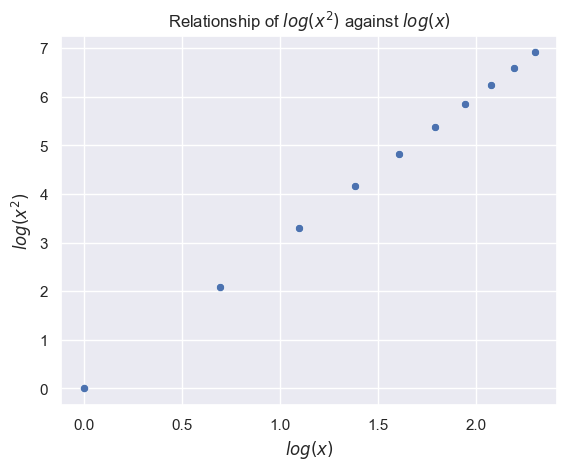

In [134]:
x = np.arange(1, 11)
y = Power(x, 3)

ax = sns.scatterplot(x=np.log(x), y=np.log(y))
plt.xlabel('$log(x)$')
plt.ylabel('$log(x^2)$')
plt.title('Relationship of $log(x^2)$ against $log(x)$')
plt.show();

### (f) Create a function, PlotPower(), that allows you to create a plot of x against x^a for a fixed a and for a range of values of x. For instance, if you call

```
> PlotPower (1:10 ,3)
```

### then a plot should be created with an x-axis taking on values 1,2,...,10, and a y-axis taking on values 13,23,...,103.

In [135]:
def PlotPower(start, stop, power):
    x = np.arange(start, stop+1)
    y = np.power(x, power)
    
    ax = sns.scatterplot(x=x, y=y)
    plt.xlabel('$x$')
    plt.ylabel('$x^{}$'.format(power))
    plt.title('Relationship of $x^{}$ against $x$'.format(power))
    plt.show();
    

def PlotPowerLogs(start, stop, power):
    x = np.arange(start, stop+1)
    y = np.power(x, power)
    
    ax = sns.scatterplot(x=np.log(x), y=np.log(y))
    plt.xlabel('$log(x)$')
    plt.ylabel('$log(x^{})$'.format(power))
    plt.title('Relationship of $log(x^{})$ against $log(x)$'.format(power))
    plt.show();

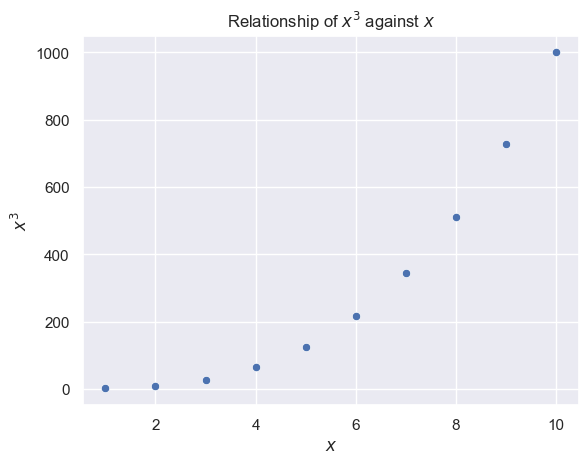

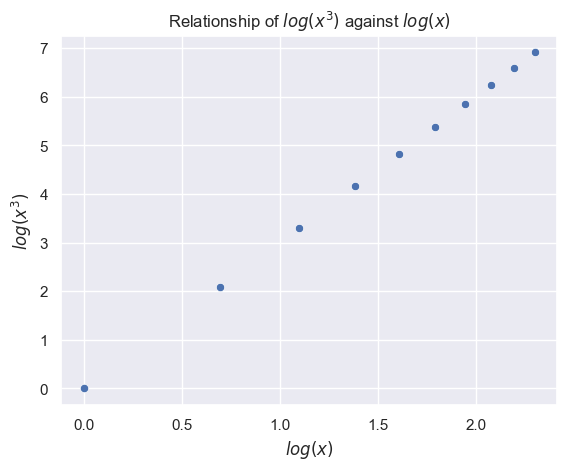

In [136]:
PlotPower(1, 10, 3)
PlotPowerLogs(1, 10, 3)

## 13. Using the Boston data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, and KNN models using various subsets of the predictors. Describe your findings.

In [137]:
boston = pd.read_csv('./data/boston_house_prices.csv', header=1)
print(boston)
# Check for missing values
assert boston.isnull().sum().sum() == 0

# Add "crime is above median" logistic response
crim01 = (boston['CRIM'] > boston['CRIM'].median()).astype(np.float64).rename('CRIM01')
boston_df = pd.concat([boston, crim01], axis=1).drop('CRIM', axis=1)

# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.7

boston_df[train].head()

        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...  ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  3

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIM01
0,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0.0
2,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0.0
3,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0.0
4,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0.0
5,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7,0.0


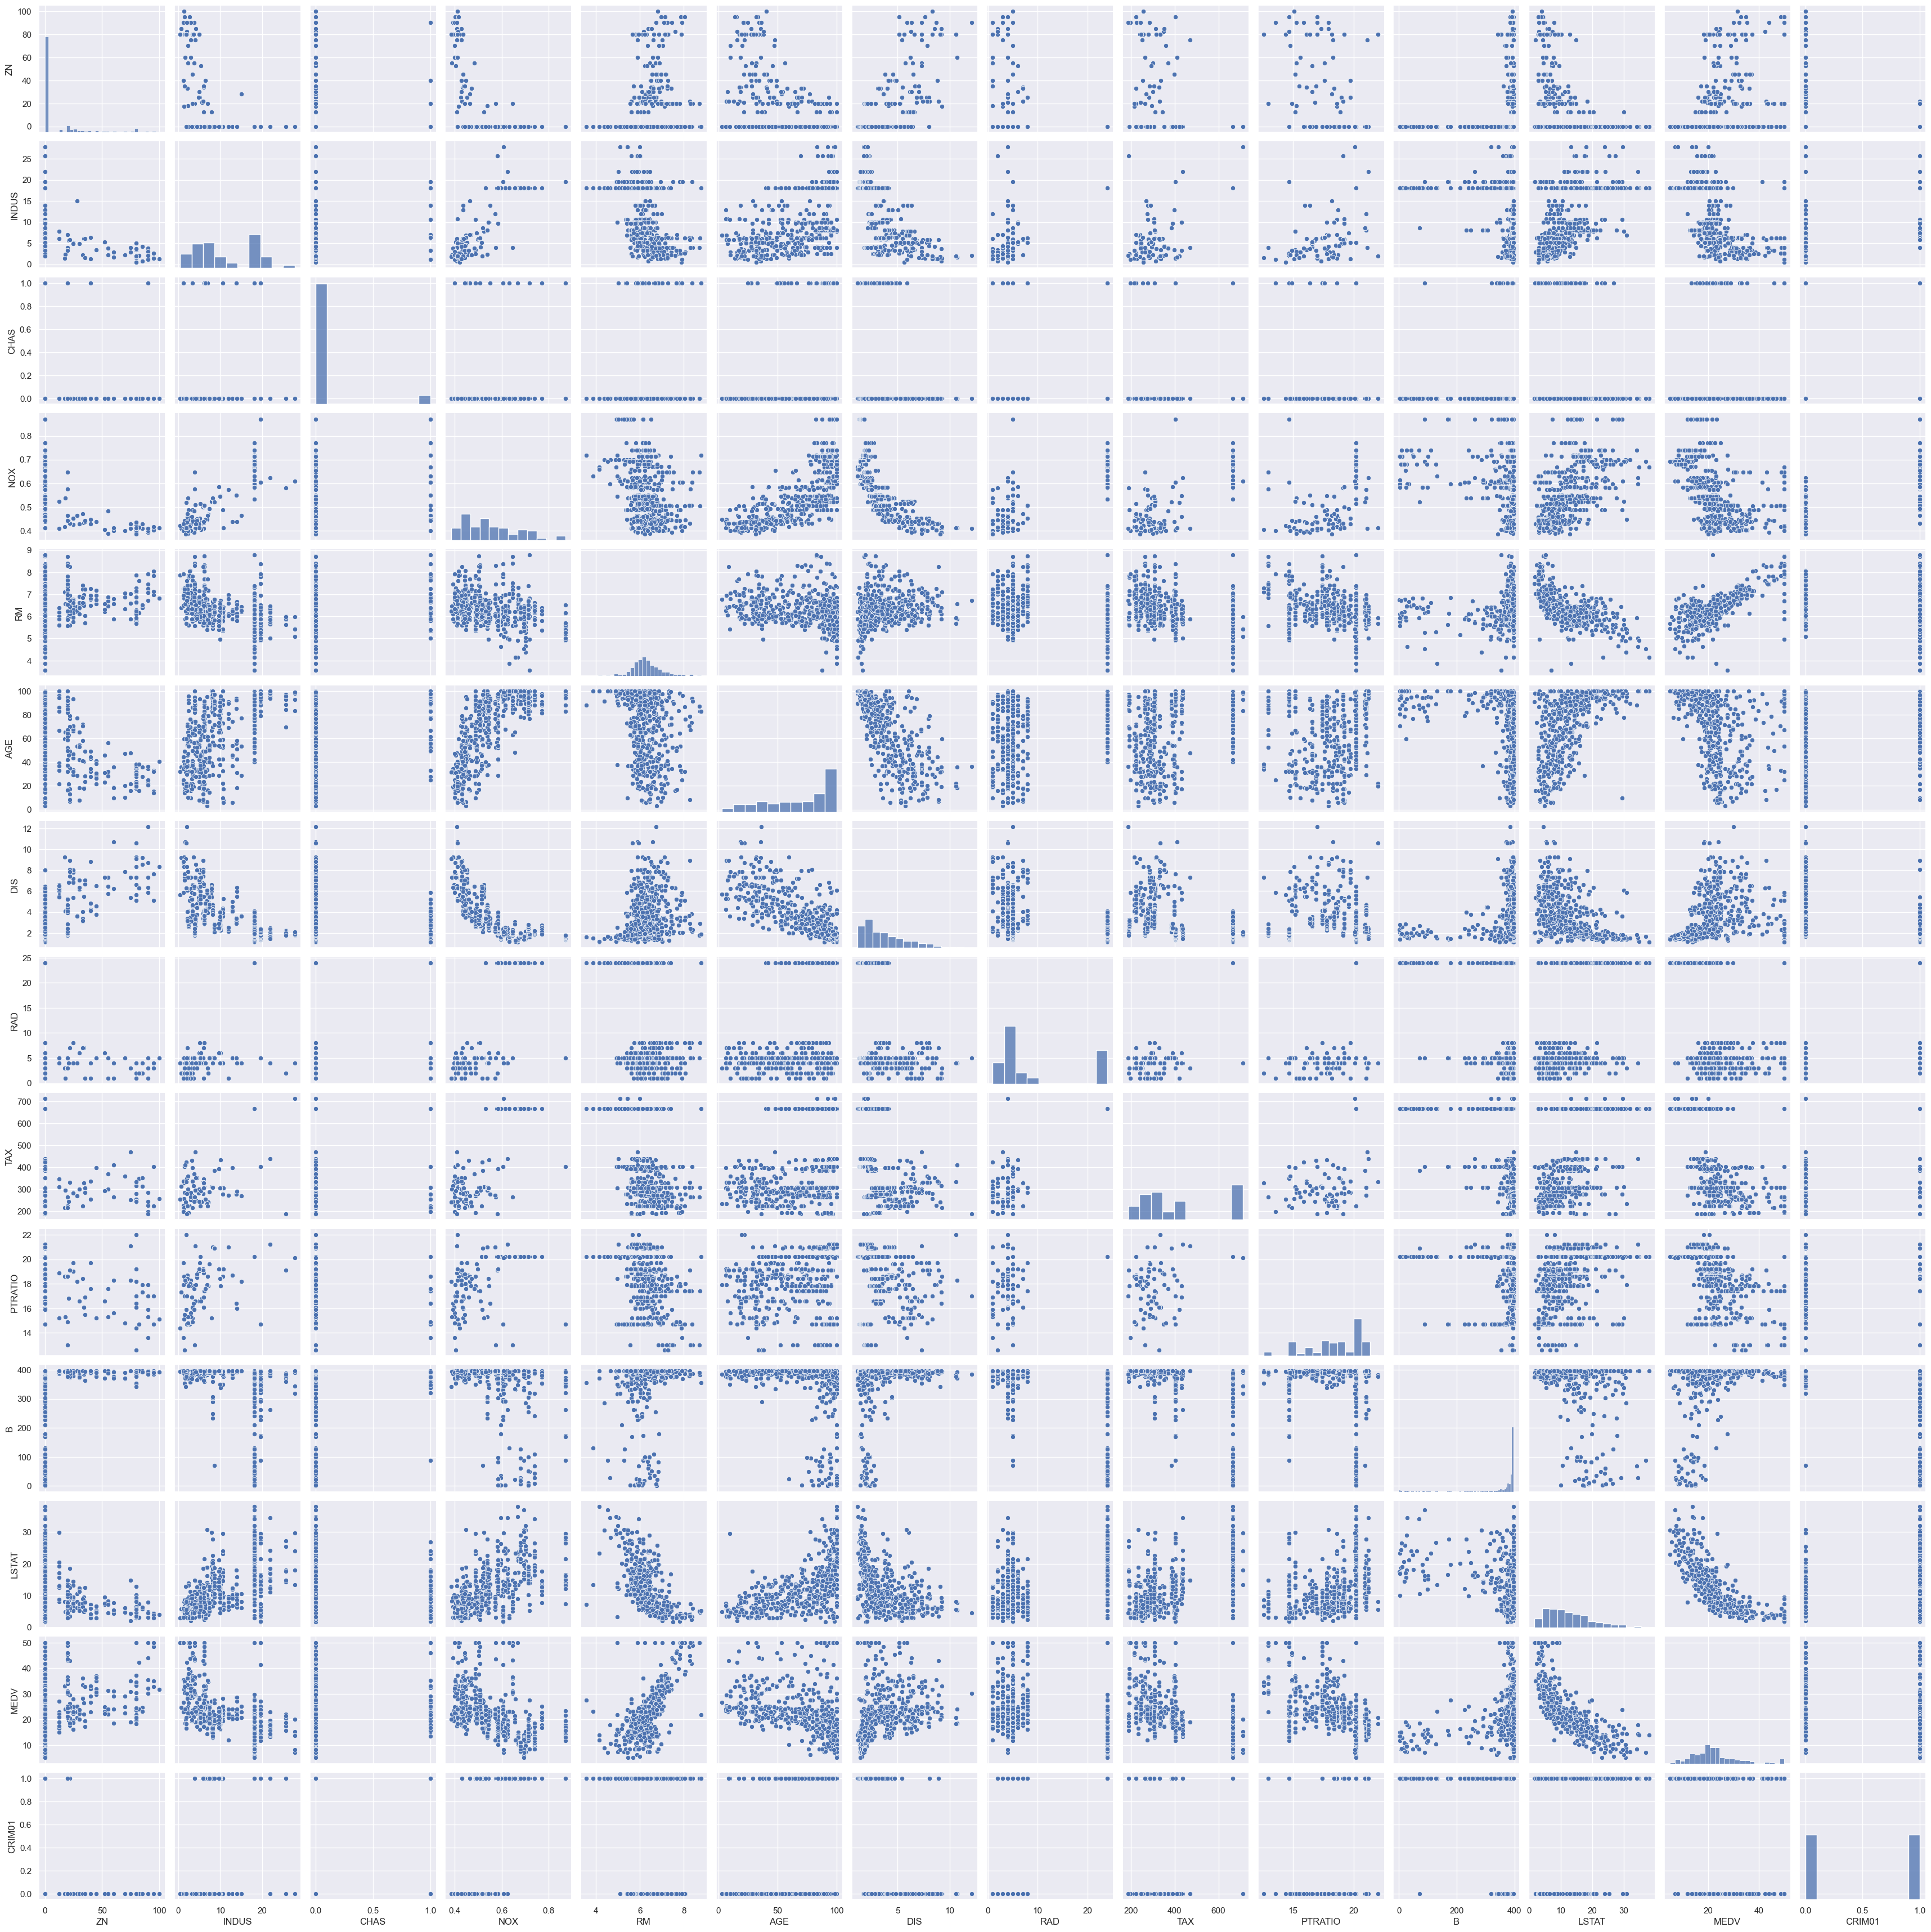

In [138]:
sns.pairplot(boston_df);

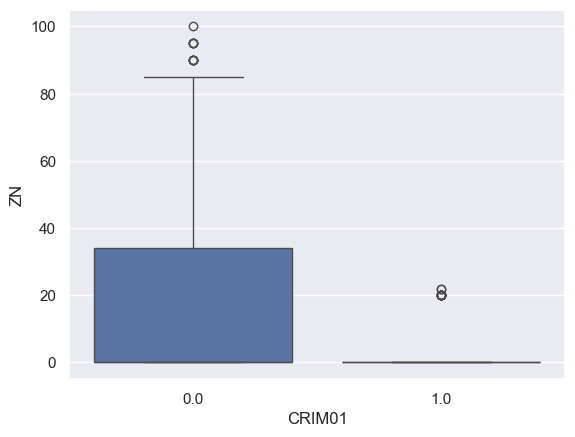

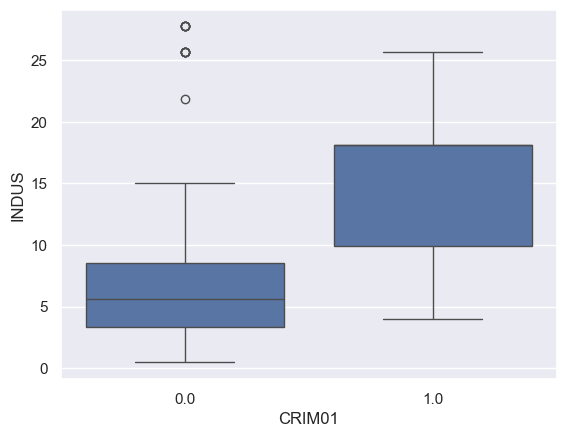

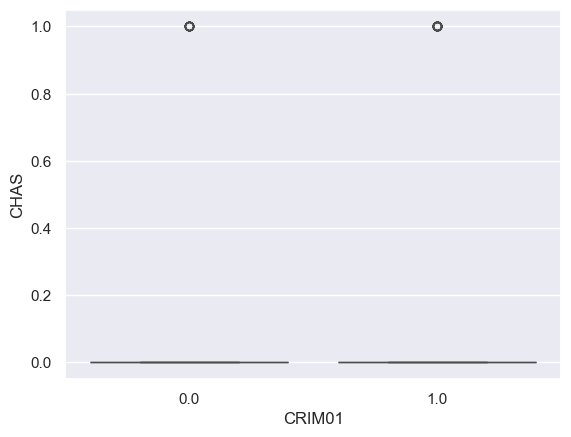

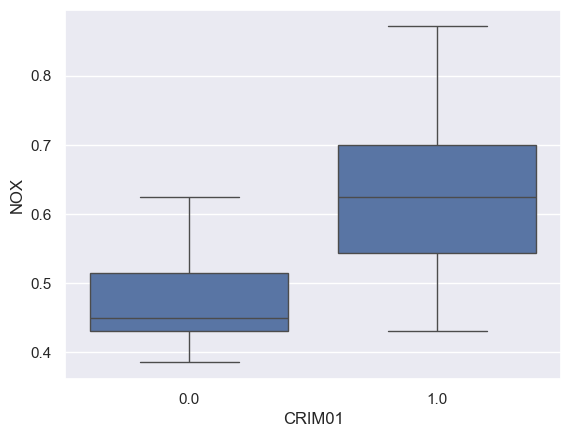

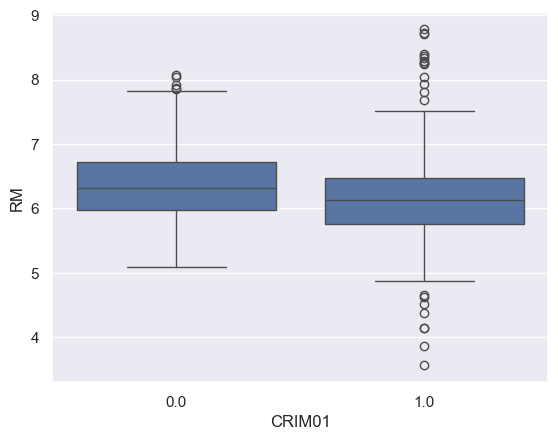

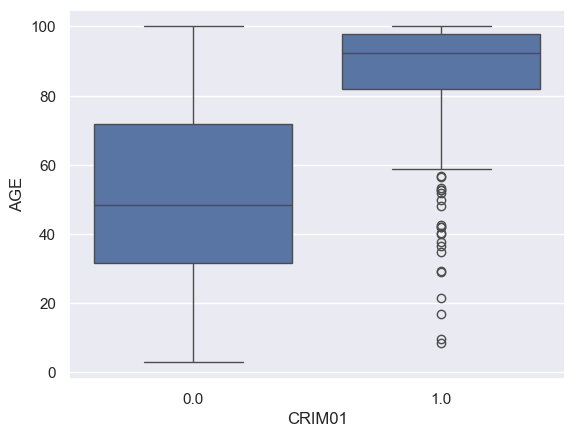

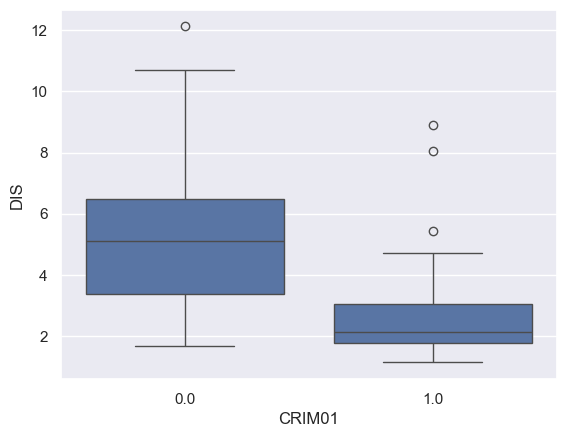

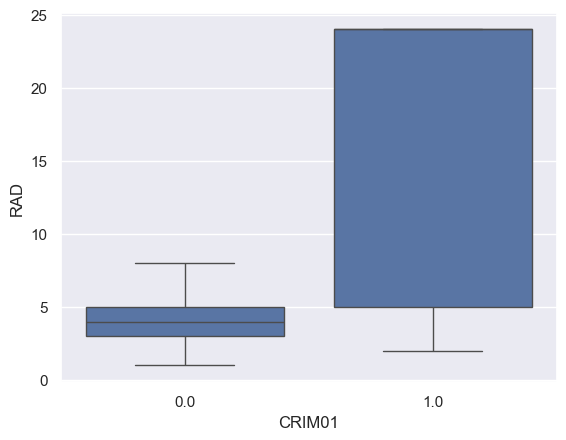

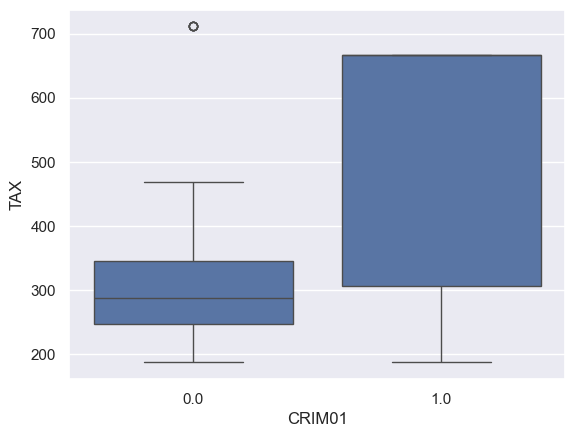

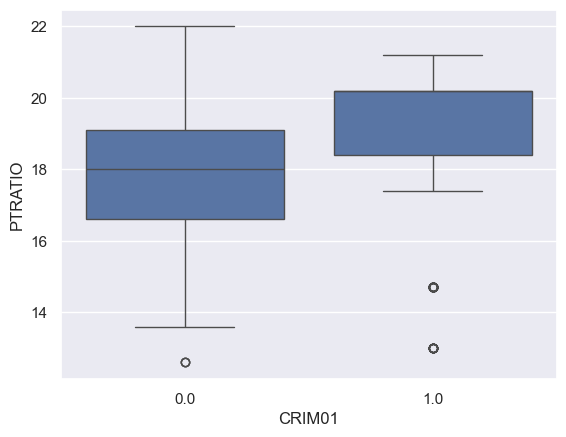

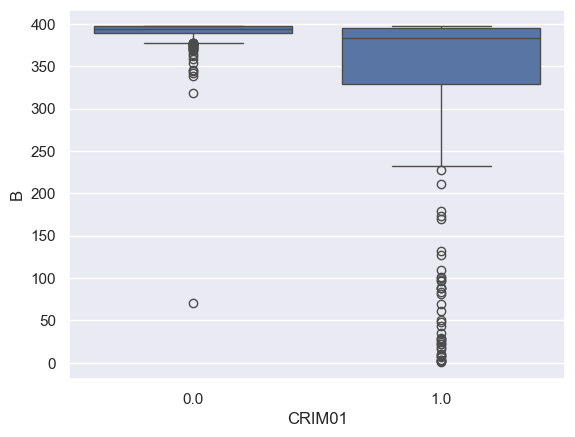

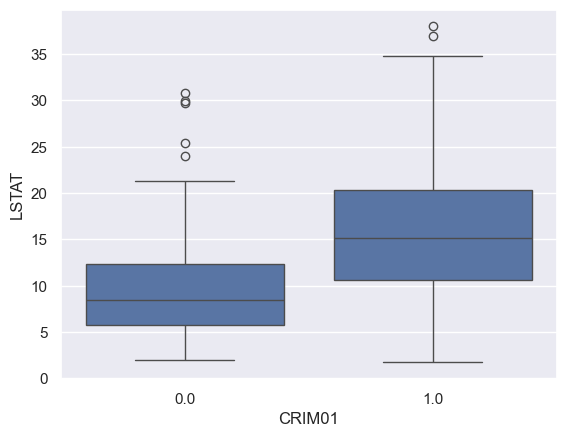

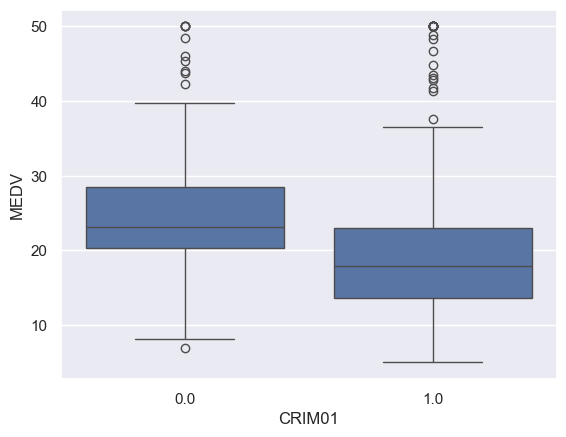

In [139]:
for c in boston_df.columns.drop(['CRIM01']):
    sns.boxplot(x=boston_df['CRIM01'], y=boston_df[c])
    plt.show();

In [140]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.7

response   = 'CRIM01'
predictors = ['NOX', 'RM', 'DIS', 'RAD', 'LSTAT', 'ZN', 'TAX', 'INDUS', 'PTRATIO']


X_train = np.array(boston_df[train][predictors])
X_test  = np.array(boston_df[~train][predictors])
y_train = np.array(boston_df[train][response])
y_test  = np.array(boston_df[~train][response])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)


models = {'logit': model_logit, 
          'lda': model_lda, 
          'qda': model_qda}


# PREDICT
for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(classifier_stats(confusion_mtx))



C:\Users\ingpe\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,y_pred=0,y_pred=1,Total
,,,
y=0,63,12,75
y=1,16,66,82
Total,79,78,


prior_error_rate                         0.477707
total_error_rate                         0.178344
true_positive_rate (sensitivity)         0.804878
false_negative_rate                      0.195122
false_positive_rate                      0.160000
true_negative_rate (specificity)         0.840000
positive_predictive_value (precision)    0.846154
negative_predictive_value                0.797468
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,72,3,75
y=1,21,61,82
Total,93,64,


prior_error_rate                         0.477707
total_error_rate                         0.152866
true_positive_rate (sensitivity)         0.743902
false_negative_rate                      0.256098
false_positive_rate                      0.040000
true_negative_rate (specificity)         0.960000
positive_predictive_value (precision)    0.953125
negative_predictive_value                0.774194
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,5,77,82
Total,79,78,


prior_error_rate                         0.477707
total_error_rate                         0.038217
true_positive_rate (sensitivity)         0.939024
false_negative_rate                      0.060976
false_positive_rate                      0.013333
true_negative_rate (specificity)         0.986667
positive_predictive_value (precision)    0.987179
negative_predictive_value                0.936709
dtype: float64

**Comment**

- QDA yields an total error of 3.82%. Far superior to Logistic and LDA. This is not suprising given the non-linear relationships apparent in the pairwise plots above.
- Feature scaling, and log transforms both increased the error rate. 
- To achive the above results I started with the 'NOX' feature which appeared strongest in plots, then iteratively tried adding an additional feature – I chose the feature that yielded the greatest reduction in total_error_rate. I repeated this process to choose the next feature and so on.


In [141]:
# Create index for holdout set
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.7

response   = 'CRIM01'
predictors = ['NOX', 'RM', 'DIS', 'RAD', 'LSTAT', 'ZN', 'TAX', 'INDUS', 'PTRATIO']

X_train = preprocessing.scale(np.array(boston_df[train][predictors]))
X_test  = preprocessing.scale(np.array(boston_df[~train][predictors]))
y_train = np.array(boston_df[train][response])
y_test  = np.array(boston_df[~train][response])



# PREDICT
for K in range(1, 21):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    
    # Classifier stats
    print('total_error_rate: \n' + str(classifier_stats(confusion_mtx)['total_error_rate']))

,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,7,75,82
Total,80,77,


total_error_rate: 
0.0573248407643312


,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,10,72,82
Total,84,73,


total_error_rate: 
0.07006369426751591


,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,9,73,82
Total,83,74,


total_error_rate: 
0.06369426751592355


,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,10,72,82
Total,84,73,


total_error_rate: 
0.07006369426751591


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,8,74,82
Total,81,76,


total_error_rate: 
0.06369426751592355


,y_pred=0,y_pred=1,Total
,,,
y=0,74,1,75
y=1,11,71,82
Total,85,72,


total_error_rate: 
0.07643312101910826


,y_pred=0,y_pred=1,Total
,,,
y=0,71,4,75
y=1,10,72,82
Total,81,76,


total_error_rate: 
0.08917197452229297


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,12,70,82
Total,85,72,


total_error_rate: 
0.08917197452229297


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,10,72,82
Total,83,74,


total_error_rate: 
0.07643312101910826


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,14,68,82
Total,87,70,


total_error_rate: 
0.10191082802547768


,y_pred=0,y_pred=1,Total
,,,
y=0,71,4,75
y=1,13,69,82
Total,84,73,


total_error_rate: 
0.10828025477707004


,y_pred=0,y_pred=1,Total
,,,
y=0,72,3,75
y=1,15,67,82
Total,87,70,


total_error_rate: 
0.1146496815286624


,y_pred=0,y_pred=1,Total
,,,
y=0,68,7,75
y=1,14,68,82
Total,82,75,


total_error_rate: 
0.13375796178343946


,y_pred=0,y_pred=1,Total
,,,
y=0,69,6,75
y=1,15,67,82
Total,84,73,


total_error_rate: 
0.13375796178343946


,y_pred=0,y_pred=1,Total
,,,
y=0,68,7,75
y=1,14,68,82
Total,82,75,


total_error_rate: 
0.13375796178343946


,y_pred=0,y_pred=1,Total
,,,
y=0,71,4,75
y=1,19,63,82
Total,90,67,


total_error_rate: 
0.14649681528662417


,y_pred=0,y_pred=1,Total
,,,
y=0,71,4,75
y=1,17,65,82
Total,88,69,


total_error_rate: 
0.13375796178343946


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,20,62,82
Total,93,64,


total_error_rate: 
0.14012738853503182


,y_pred=0,y_pred=1,Total
,,,
y=0,72,3,75
y=1,20,62,82
Total,92,65,


total_error_rate: 
0.14649681528662417


,y_pred=0,y_pred=1,Total
,,,
y=0,73,2,75
y=1,21,61,82
Total,94,63,


total_error_rate: 
0.14649681528662417


**Comment**

- K=1 os the strongest KNN model with total error of 5.73%, so is inferior to QDA at 3.82%
- The optimal features for QDA also seem to be optimal for KNN
- scaling: Suprisingly, mean removal and variance scaling does not improve results. Scaling to (0,1) range worsens results
- transform: log1p transform of features worsens results
